In [2]:
#!pip install -q condacolab
#import condacolab
#condacolab.install()

In [3]:
#!conda install -c sebp scikit-survival
!pip install scikit-survival

# 1. Weibull

Commençons par l'estimation des paramètres d'une Weibull.

In [4]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import weibull_min

%matplotlib inline

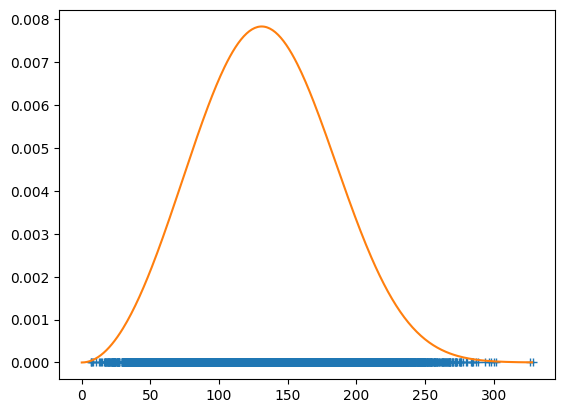

In [5]:
k = 3
lambda_w = 150

equipement_life = weibull_min.rvs(k, loc=0, scale=lambda_w, size=10000)
plt.plot(equipement_life, np.zeros(10000), '+')
d = np.arange(0, np.max(equipement_life))
survival = (k/lambda_w) * np.power((d/lambda_w),(k-1))*np.exp(-np.power((d/lambda_w), k))
plt.plot(d, survival)

1.1. Estimez k et lambda

estimation k: [[2.6575853]] estimation lambda: [[142.9745564]]


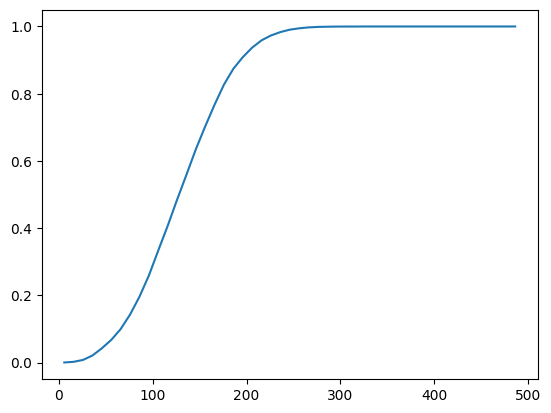

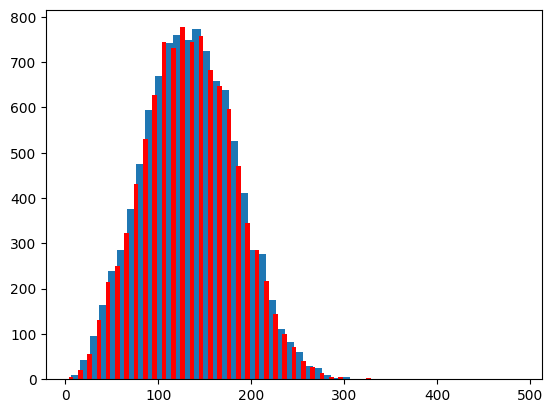

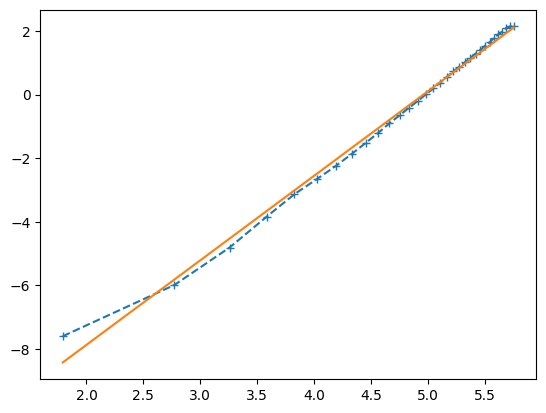

In [6]:
from sklearn.linear_model import LinearRegression
# Réponse
equipement_life = np.sort(equipement_life)
t = np.arange(1, 500, 10)
f, v = np.histogram(equipement_life, t)

F = np.cumsum(f)
F = F / 10000
plt.plot((v[0:-1]+v[1:])/2, F)

F_complet = F
t = (t[0:-1]+t[1:])/2
t_complet = t
t = t_complet[(1 - F_complet)>0]
F = F_complet[(1 - F_complet)>0]
logt = np.log(t)
loglogF = np.log(-np.log(1-F))

lr = LinearRegression()
lr.fit(logt.reshape(-1, 1), loglogF.reshape(-1, 1))

k_hat = lr.coef_
lambda_hat = np.exp(lr.intercept_/(-k_hat))

plt.figure()
plt.hist(equipement_life, t)
plt.bar((v[0:-1]+v[1:])/2, f, width=5, color='r')
plt.figure()
plt.plot(logt, loglogF,'+--')
plt.plot(logt, lr.predict(logt.reshape(-1, 1)));
print('estimation k:', k_hat, 'estimation lambda:', lambda_hat)

1.2.Estimez les valeurs de k et lambda par maximum de vraisemblance.

In [7]:
import scipy.optimize

# réponse
def F(k):
    return np.sum((equipement_life**k)*np.log(equipement_life))/np.sum((equipement_life**k)) - 1/k - np.mean(np.log(equipement_life))
k_hat = scipy.optimize.broyden1(F, [3], f_tol=1e-5)
print(k_hat)
lambda_hat = np.mean(equipement_life**k_hat)**(1/k_hat)

print(lambda_hat)

[2.99679932]
[150.35544984]


1.3. Faites varier le nombre d'échantillons, et comparez les deux méthodes.

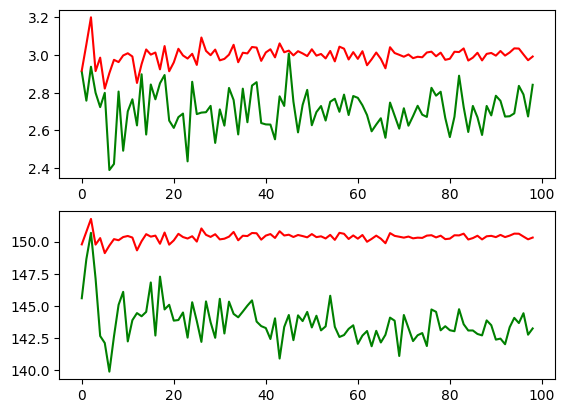

In [8]:
# Réponse
def estim_weibull_graph(samples):
    equipement_life = np.sort(samples)
    t = np.arange(1, np.max(samples), 10)
    f, v = np.histogram(equipement_life, t)
    F = np.cumsum(f)
    F = F / len(samples)
    F_complet = F
    t = (t[0:-1]+t[1:])/2
    t_complet = t
    t = t_complet[((1 - F_complet)>0)&(F_complet>0)]
    F = F_complet[((1 - F_complet)>0)&(F_complet>0)]
    logt = np.log(t)
    loglogF = np.log(-np.log(1-F))
    mf = LinearRegression()
    lr.fit(logt.reshape(-1, 1), loglogF.reshape(-1, 1))
    k_hat = lr.coef_
    lambda_hat = np.exp(lr.intercept_/(-k_hat))
    return k_hat, lambda_hat

def estim_weibull_ML(samples):
    def F(k):
        return np.sum((samples**k)*np.log(samples))/np.sum((samples**k)) - 1/k - np.mean(np.log(samples))
    k_hat = scipy.optimize.broyden1(F, [3], f_tol=1e-5)
    lambda_hat = np.mean(equipement_life**k_hat)**(1/k_hat)
    return k_hat, lambda_hat

range_to_test = range(100, 10000, 100)
k_hat_g = np.zeros(len(range_to_test))
k_hat_ml = np.zeros(len(range_to_test))
lambda_hat_g = np.zeros(len(range_to_test))
lambda_hat_ml = np.zeros(len(range_to_test))
for i, nb_samples in enumerate(range_to_test):
    samples = weibull_min.rvs(k, loc=0, scale=lambda_w, size=nb_samples)
    k_hat_g[i], lambda_hat_g[i] = estim_weibull_graph(samples)
    k_hat_ml[i], lambda_hat_ml[i] = estim_weibull_ML(samples)

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(k_hat_g, 'g')
plt.plot(k_hat_ml, 'r')
plt.subplot(2, 1, 2)
plt.plot(lambda_hat_g, 'g')
plt.plot(lambda_hat_ml, 'r');

# 2. Kaplan-Meier

2.1 Implémentez l'estimateur de Kaplan-Meier.

1 8 1 0.125 0.875
1 7 0.875 0.14285714285714285 0.8571428571428572
1 6 0.75 0.16666666666666666 0.8333333333333334
0 4 0.625 0.0 1.0
1 3 0.625 0.3333333333333333 0.6666666666666667
1 2 0.41666666666666674 0.5 0.5


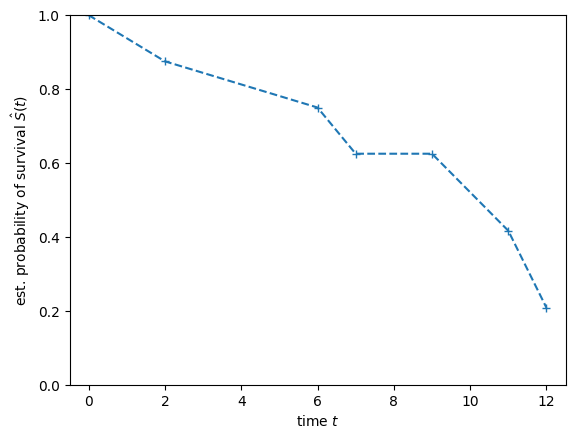

In [9]:
## Example Data
durations = np.array([2,7,12,12,6,7,9, 11])
event_observed = np.array([1, 0, 0, 1, 1, 1, 0, 1])
# Réponse
S = [1]
for t in np.sort(np.unique(durations)):
    d = np.sum((durations == t) & (event_observed==1))
    n = np.sum(durations>=t)
    print(d, n, S[-1], d/n, (1-d/n))
    S.append(S[-1]*(1-d/n))

plt.plot(np.concatenate([[0], np.unique(durations)]), S, '--+');
plt.ylabel("est. probability of survival $\hat{S}(t)$");
plt.xlabel("time $t$");
plt.axis([-0.5, 12.5, 0, 1]);


2.2 Utilisez scikit-survival pour calculer un estimateur de Kaplan-Meier.

(-0.5, 12.5, 0.0, 1.0)

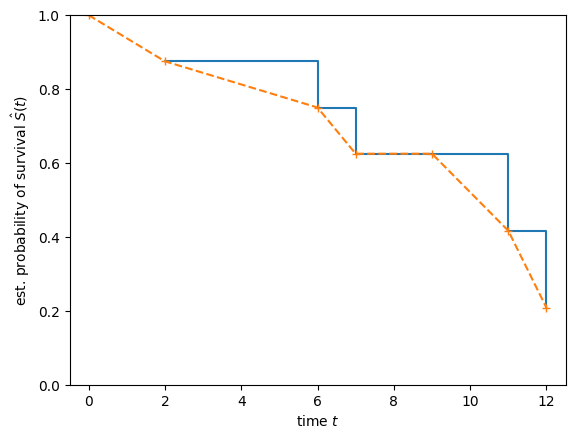

In [10]:
# Importing modules
import numpy as np
from matplotlib import pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(event_observed.astype(bool), durations)

plt.step(time, survival_prob, where="post")
plt.plot(np.concatenate([[0], np.unique(durations)]), S, '--+');
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.axis([-0.5, 12.5, 0, 1])


# 3 Influence des covariates

Nous prenons ici un dataset de maintenance prédictive. Il concerne un ensemble de machines, et leurs dates de panne. Il contient des descripteurs d'environnement, mais aussi des descripteurs sur qui a utilisé la machine (team) et qui l'a produite (provider). Nous ne nous occuperons que de la partie team & provider.

In [11]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

raw_dataset = pd.read_csv('data/maintenance.csv', sep=';')
raw_dataset.head()

,lifetime,broken,pressureInd,moistureInd,temperatureInd,team,provider
0,56,0,92.178854,104.230204,96.517159,TeamA,Provider4
1,81,1,72.075938,103.065701,87.271062,TeamC,Provider4
2,60,0,96.272254,77.801376,112.196170,TeamA,Provider1
3,86,1,94.406461,108.493608,72.025374,TeamC,Provider2
4,34,0,97.752899,99.413492,103.756271,TeamB,Provider1


In [12]:
time_column = 'lifetime'
event_column = 'broken'

categories = ['provider', 'team']
dataset = pd.get_dummies(raw_dataset, columns = categories)

Covariates = dataset.loc[: , ['provider_Provider1',
                              'provider_Provider2',
                              'provider_Provider3',
                              'provider_Provider4',
                              'team_TeamA',
                              'team_TeamB',
                              'team_TeamC']]

Time = dataset.loc[:, time_column]
Event = dataset.loc[:, event_column]
print(Covariates.head())

   provider_Provider1  provider_Provider2  provider_Provider3  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   1                   0                   0   
3                   0                   1                   0   
4                   1                   0                   0   

   provider_Provider4  team_TeamA  team_TeamB  team_TeamC  
0                   1           1           0           0  
1                   1           0           0           1  
2                   0           1           0           0  
3                   0           0           0           1  
4                   0           0           1           0  


3.1 Visualisez les données.

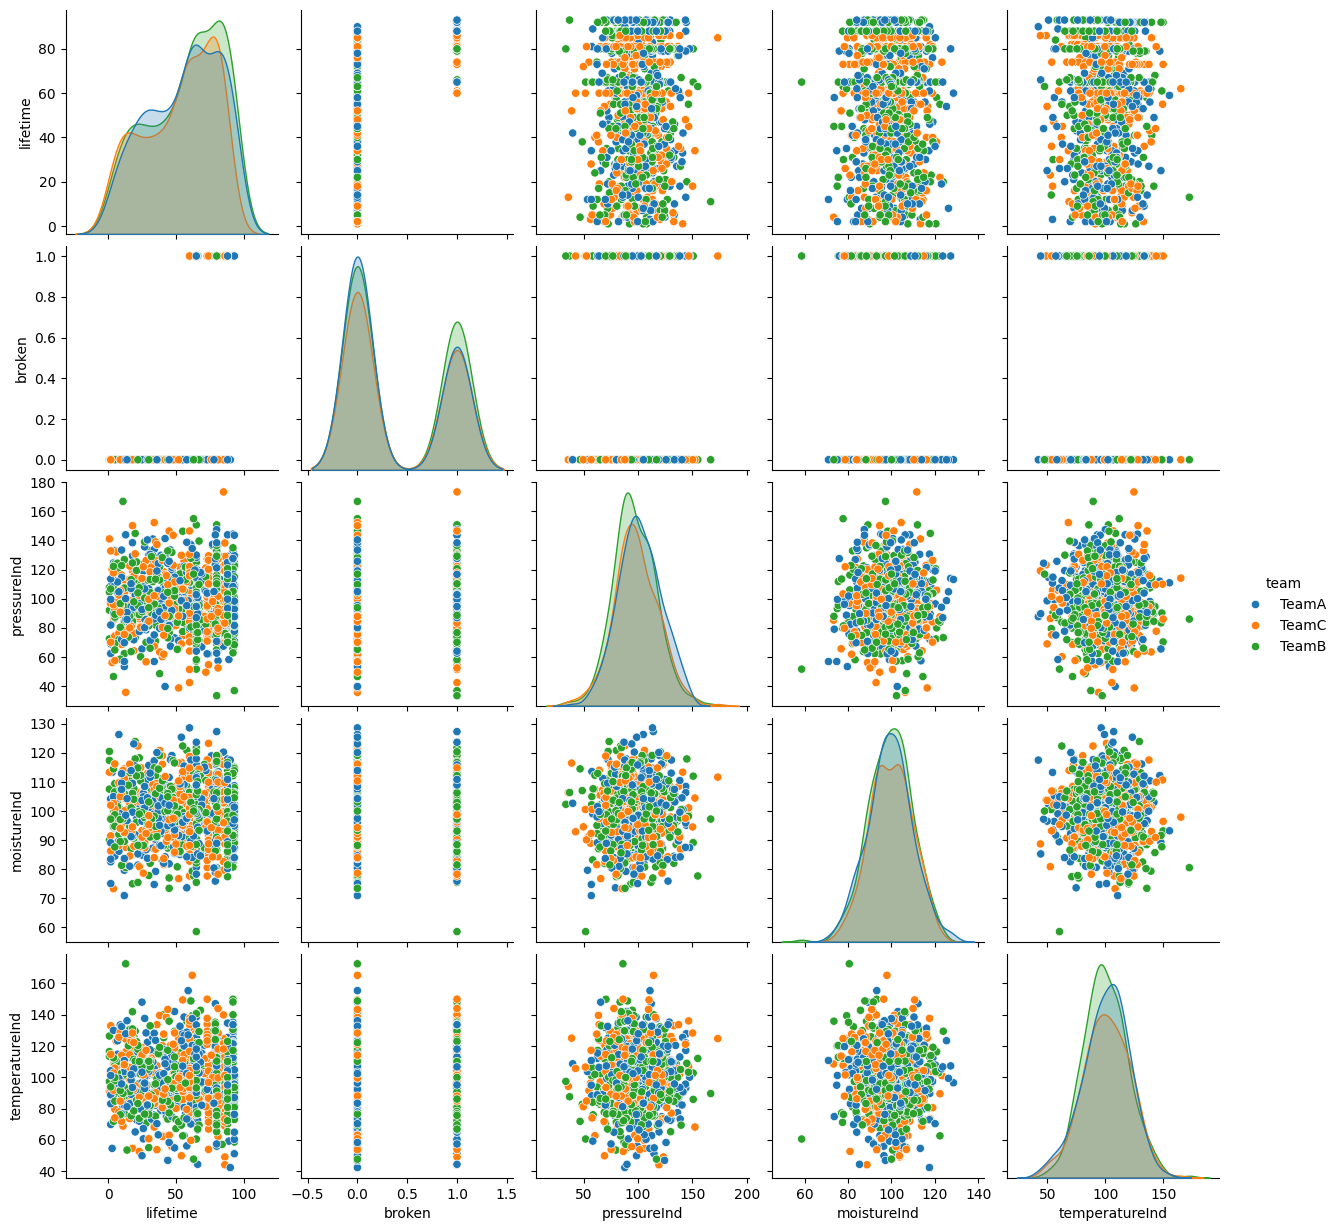

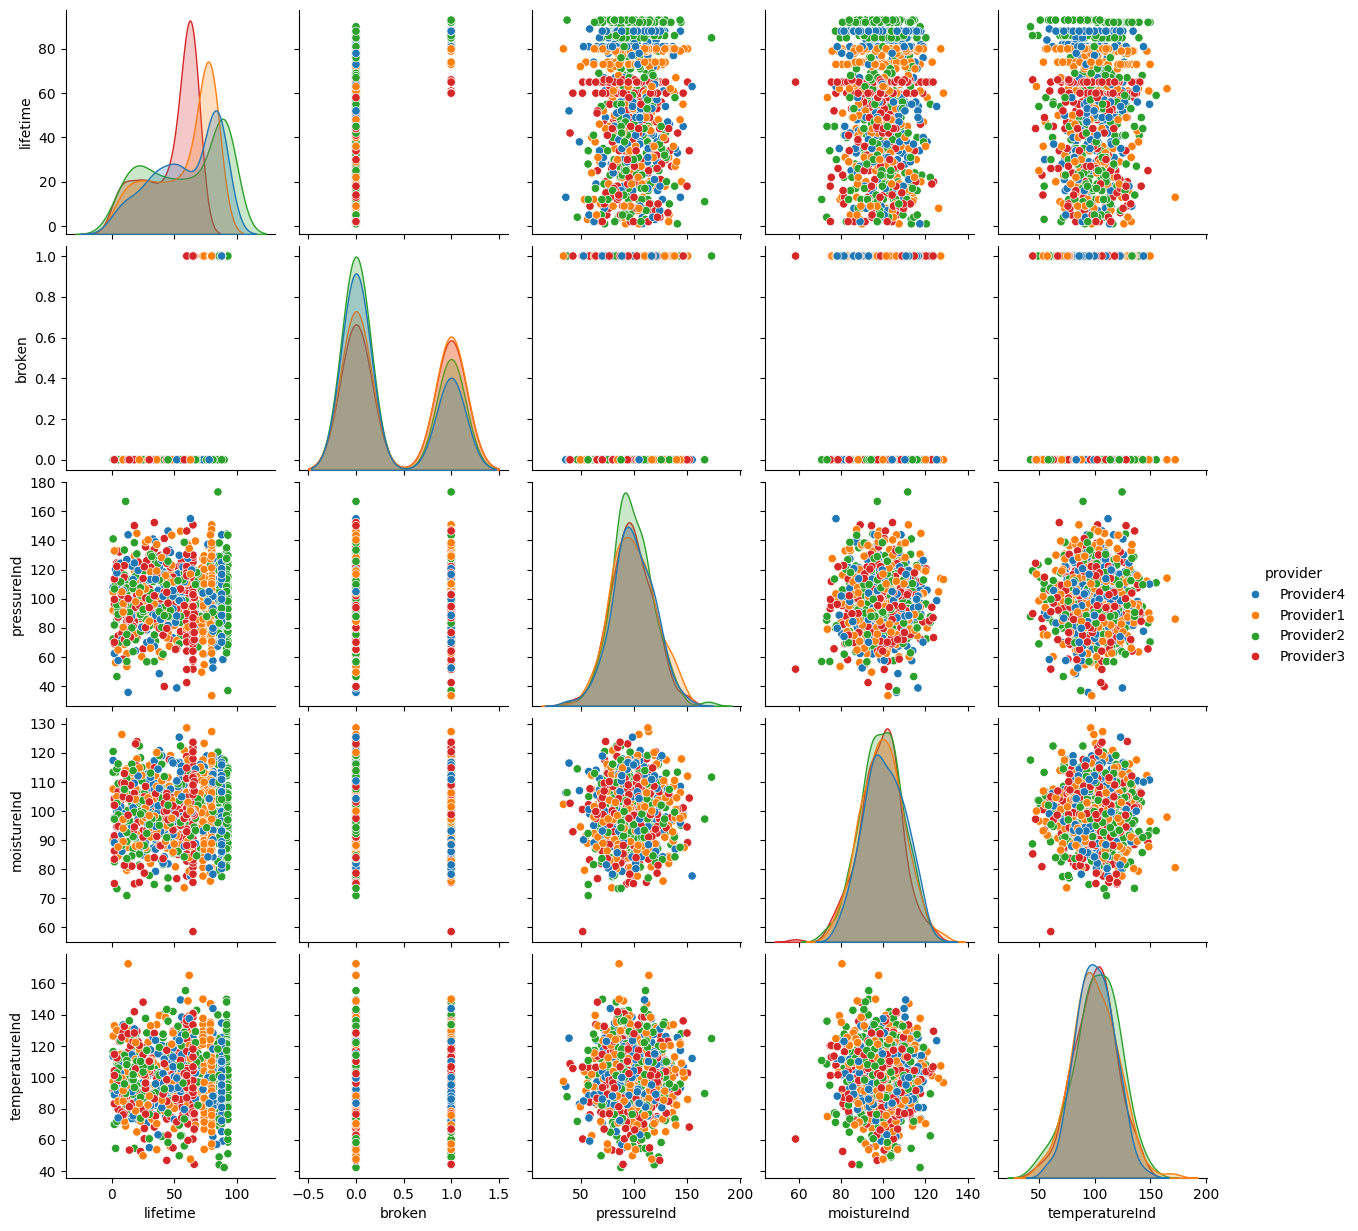

In [13]:
import seaborn as sns
sns.pairplot(raw_dataset.loc[:, ['lifetime', 'broken','pressureInd', 'moistureInd', 'temperatureInd', 'team']], hue='team');
sns.pairplot(raw_dataset.loc[:, ['lifetime', 'broken','pressureInd', 'moistureInd', 'temperatureInd', 'provider']], hue='provider');

3.2 Estimez les lois de vie pour les covariates suivants avec Kaplan-Meier et affichez les résultats sur une même figure :
- provider
- team

team_TeamA
team_TeamB
team_TeamC


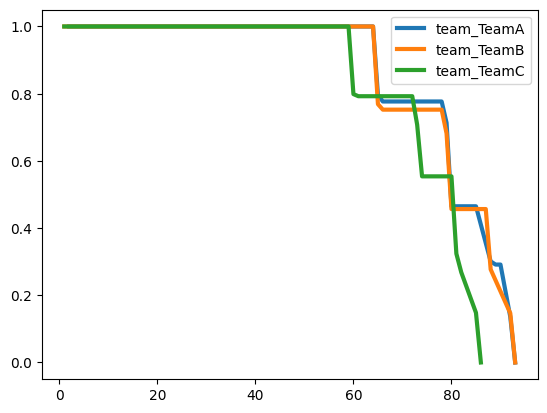

In [14]:
legends = []
for g in ['team_TeamA', 'team_TeamB', 'team_TeamC']:
    print(g)
    legends.append(g)
    durations = Time.loc[Covariates[g]==1]
    event = Event.loc[Covariates[g]==1]
    times, survival = kaplan_meier_estimator(event.astype(bool), durations)
    plt.plot(times, survival, label = g, lw = 3)

plt.legend(legends)

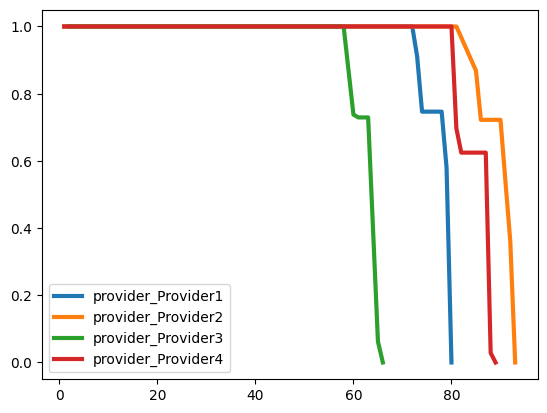

In [15]:
legends = []
plt.figure()
for g in ['provider_Provider1',
          'provider_Provider2',
          'provider_Provider3',
          'provider_Provider4']:
    legends.append(g)
    durations = Time.loc[Covariates[g]==1]
    event = Event.loc[Covariates[g]==1]
    times, survival = kaplan_meier_estimator(event.astype(bool), durations)
    plt.plot(times, survival, label = g, lw = 3)

plt.legend(legends);

3.3 Apprenez un modèle de Cox sur ces données. Analysez vos résultats en comparant les coefficients. Cela correspond-t-il aux courbes que vous avez observées ?

In [16]:
import warnings

def fxn():
    warnings.warn("LinAlgWarning", DeprecationWarning)



In [17]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
# Réponse
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    y =  [(e, t) for e, t in zip(Event.astype(bool), Time)]
    y = np.array(y, dtype=[('Event', 'b1'), ('Time', 'f4')])
    estimator = CoxPHSurvivalAnalysis().fit(Covariates, y)
    for name, coef in zip(Covariates.keys(), estimator.coef_):
        print(name, coef)

provider_Provider1 -22.907538263956965
provider_Provider2 -103.00681598699572
provider_Provider3 38.94409983592524
provider_Provider4 -82.68245079749957
team_TeamA 23.79899359496602
team_TeamB 23.797001455243382
team_TeamC 63.768840517469805


3.4. Calculer le Concordance-index sur le dataset.

In [18]:
# réponse
# Courte
estimator.score(Covariates, y)

# Détaillée
from sksurv.metrics import concordance_index_censored
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    y =  [(e, t) for e, t in zip(Event.astype(bool), Time)]
    y = np.array(y, dtype=[('Event', 'b1'), ('Time', 'f4')])

    cph = CoxPHSurvivalAnalysis().fit(Covariates, y)
    cindex, concordant, discordant, tied_risk, tied_time = concordance_index_censored(np.array(Event, dtype=bool), Time, estimate=cph.predict(Covariates), tied_tol=1e-08)
    print('c-index:', cindex)
    print('concordant pairs:', concordant)
    print('paires avec le même risque:', tied_risk)
    print('paires avec le même temps:', tied_time)

c-index: 0.9796283181797414
concordant pairs: 84699
paires avec le même risque: 2131
paires avec le même temps: 1635


3.5 Apprenez un Random Survival Forest sur ce données et calculez le Concordance-index.

In [19]:
from sksurv.ensemble import RandomSurvivalForest
# Réponse
y =  [(e, t) for e, t in zip(Event.astype(bool), Time)]
y = np.array(y, dtype=[('Event', 'b1'), ('Time', 'f4')])
estimator = RandomSurvivalForest().fit(Covariates, y)
estimator.score(Covariates, y)

0.9316432128660849

3.6 Comparez plus rigoureusement les deux modèles, par 2 changements dans l'analyse.

In [24]:
# Les 2 changements : ajouter une métrique, ajouter une séparation train / test
from sklearn.model_selection import train_test_split
from sksurv.metrics import integrated_brier_score

nb_test = 10
all_cph_ci = np.zeros(nb_test)
all_rsf_ci = np.zeros(nb_test)
all_cph_bs = np.zeros(nb_test)
all_rsf_bs = np.zeros(nb_test)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    i, rs = 0, 0
    while i < nb_test:
        rs += 1
        try:
            X_train, X_test, time_train, time_test = train_test_split(Covariates, Time, random_state=rs, test_size=0.5)
            X_train, X_test, event_train, event_test = train_test_split(Covariates, Event, random_state=rs, test_size=0.5)

            y_train =  [(e, t) for e, t in zip(event_train.astype(bool), time_train)]
            y_train = np.array(y_train, dtype=[('Event', 'b1'), ('Time', 'f4')])
            y_test =  [(e, t) for e, t in zip(event_test.astype(bool), time_test)]
            y_test = np.array(y_test, dtype=[('Event', 'b1'), ('Time', 'f4')])
            cph = CoxPHSurvivalAnalysis().fit(X_train, y_train)
            c_index_cph = cph.score(X_test, y_test)

            times = np.arange(np.min(time_test[event_test>0]), np.max(time_test))

            survs = cph.predict_survival_function(X_test)
            preds = np.asarray([[fn(t) for t in times] for fn in survs])
            bs_cph = integrated_brier_score(y_train, y_test, preds, times)

            rsf = RandomSurvivalForest(n_estimators=200).fit(X_train, y_train)
            c_index_rsf = rsf.score(X_test, y_test)

            survs = rsf.predict_survival_function(X_test)
            preds = np.asarray([[fn(t) for t in times] for fn in survs])
            bs_rsf = integrated_brier_score(y_train, y_test, preds, times)
            print('CI: Cox Model:', "%0.3f" % c_index_cph, 'SRF:', "%0.3f" % c_index_rsf)
            print('IBS: Cox Model:', "%0.3f" % bs_cph, 'SRF:', "%0.3f" % bs_rsf)
            all_cph_ci[i] = c_index_cph
            all_rsf_ci[i] = c_index_rsf
            all_cph_bs[i] = bs_cph
            all_rsf_bs[i] = bs_rsf
            i += 1
        except:
            print('fail')
    print('Cox Model:', "CI %0.3f" % np.mean(all_cph_ci), '+/-', "%0.3f" % np.std(all_cph_ci), "IBS: %0.3f" % np.mean(all_cph_bs), '+/-', "%0.3f" %np.std(all_cph_bs),
          'SRF:',  "CI %0.3f" % np.mean(all_rsf_ci), '+/-',  "%0.3f" %np.std(all_rsf_ci),   "IBS:  %0.3f" % np.mean(all_rsf_bs), '+/-',  "%0.3f" %np.std(all_rsf_bs),)

CI: Cox Model: 0.975 SRF: 0.937
IBS: Cox Model: 0.456 SRF: 0.006
fail
CI: Cox Model: 0.981 SRF: 0.963
IBS: Cox Model: 0.384 SRF: 0.004
CI: Cox Model: 0.975 SRF: 0.909
IBS: Cox Model: 0.407 SRF: 0.005
fail
CI: Cox Model: 0.978 SRF: 0.893
IBS: Cox Model: 0.396 SRF: 0.005
fail
fail
CI: Cox Model: 0.974 SRF: 0.962
IBS: Cox Model: 0.399 SRF: 0.006
CI: Cox Model: 0.979 SRF: 0.888
IBS: Cox Model: 0.471 SRF: 0.005
CI: Cox Model: 0.982 SRF: 0.947
IBS: Cox Model: 0.332 SRF: 0.003
fail
CI: Cox Model: 0.978 SRF: 0.900
IBS: Cox Model: 0.445 SRF: 0.005
CI: Cox Model: 0.978 SRF: 0.920
IBS: Cox Model: 0.310 SRF: 0.004
CI: Cox Model: 0.978 SRF: 0.888
IBS: Cox Model: 0.410 SRF: 0.004
Cox Model: CI 0.978 +/- 0.002 IBS: 0.401 +/- 0.048 SRF: CI 0.921 +/- 0.028 IBS:  0.005 +/- 0.001


In [25]:
print('Cox was better in CI for :', "%0.0f" % (100*np.mean(all_cph_ci > all_rsf_ci)), '%')
print('Cox was better in IBS for :', "%0.0f" % (100*np.mean(all_cph_bs < all_rsf_bs)), '%')

Cox was better in CI for : 100 %
Cox was better in IBS for : 0 %


3.7 Analysez vos résultats

CI: Cox Model: 0.976 SRF: 0.928
IBS: Cox Model: 0.387 SRF: 0.005


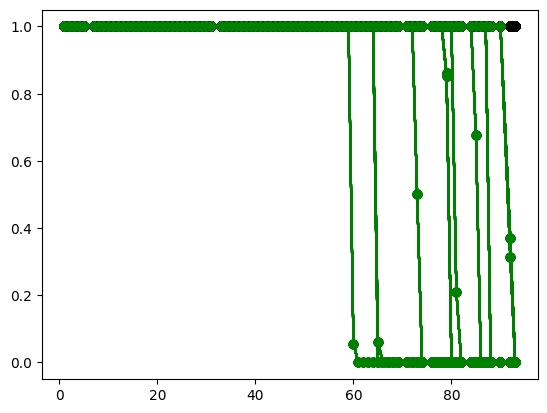

In [27]:
from sksurv.metrics import integrated_brier_score
rs = 0
i = 0
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    X_train, X_test, time_train, time_test = train_test_split(Covariates, Time, random_state=rs, test_size=0.5)
    X_train, X_test, event_train, event_test = train_test_split(Covariates, Event, random_state=rs, test_size=0.5)

    y_train =  [(e, t) for e, t in zip(event_train.astype(bool), time_train)]
    y_train = np.array(y_train, dtype=[('Event', 'b1'), ('Time', 'f4')])
    y_test =  [(e, t) for e, t in zip(event_test.astype(bool), time_test)]
    y_test = np.array(y_test, dtype=[('Event', 'b1'), ('Time', 'f4')])
    cph = CoxPHSurvivalAnalysis().fit(X_train, y_train)
    c_index_cph = cph.score(X_test, y_test)

    times = np.arange(np.min(time_test[event_test>0]), np.max(time_test))

    survs = cph.predict_survival_function(X_test)
    preds = np.asarray([[fn(t) for t in times] for fn in survs])
    bs_cph = integrated_brier_score(y_train, y_test, preds, times)
    for s in survs:
        plt.plot(s.x, s(s.x),'-ok')

    rsf = RandomSurvivalForest(n_estimators=200).fit(X_train, y_train)
    c_index_rsf = rsf.score(X_test, y_test)

    survs = rsf.predict_survival_function(X_test)
    for s in survs:
        plt.plot(s.x, s(s.x),'-og')

    preds = np.asarray([[fn(t) for t in times] for fn in survs])
    bs_rsf = integrated_brier_score(y_train, y_test, preds, times)
    print('CI: Cox Model:', "%0.3f" % c_index_cph, 'SRF:', "%0.3f" % c_index_rsf)
    print('IBS: Cox Model:', "%0.3f" % bs_cph, 'SRF:', "%0.3f" % bs_rsf)
    all_cph_ci[i] = c_index_cph
    all_rsf_ci[i] = c_index_rsf
    all_cph_bs[i] = bs_cph
    all_rsf_bs[i] = bs_rsf

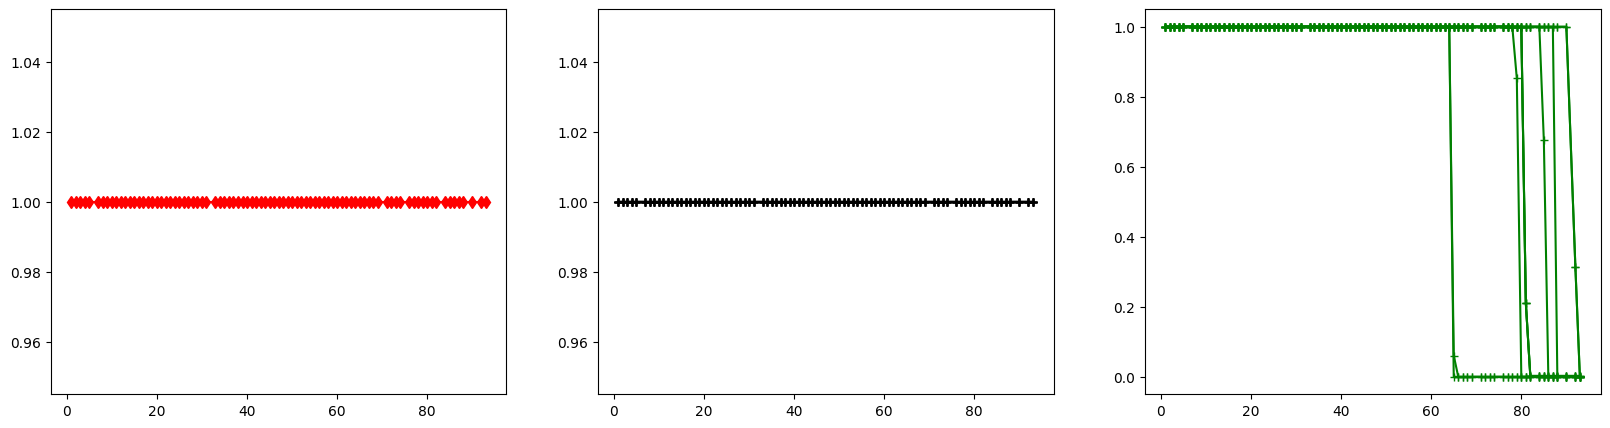

In [28]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(cph.baseline_survival_.x, cph.baseline_survival_.y, 'r-d')
cph_predictions = cph.predict_survival_function(X_test.iloc[0:10, :])
plt.subplot(1, 3, 2)
for cp in cph_predictions:
    plt.plot(cp.x, cp(cp.x), '-+k')
rsf_predictions = rsf.predict_survival_function(X_test.iloc[0:10, :])
plt.subplot(1, 3, 3)
for rs in rsf_predictions:
    plt.plot(rs.x, rs(rs.x), '-+g')

(0.0, 93.0)

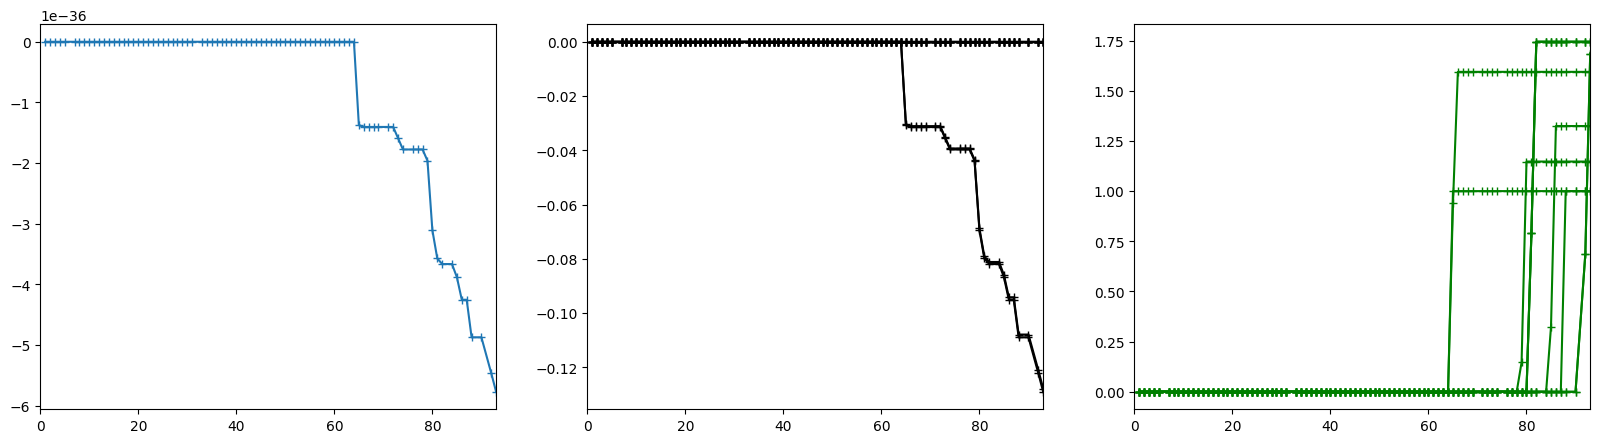

In [29]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(cph.cum_baseline_hazard_.x, cph.cum_baseline_hazard_.y, '-+')
cph_predictions = cph.predict_cumulative_hazard_function(X_test.iloc[0:10, :])
plt.xlim([0, 93])
for cp in cph_predictions:
    plt.subplot(1, 3, 2)
    plt.plot(cp.x, cp(cp.x), '-+k')
rsf_predictions = rsf.predict_cumulative_hazard_function(X_test.iloc[0:10, :])
plt.xlim([0, 93])
for rs in rsf_predictions:
    plt.subplot(1, 3, 3)
    plt.plot(rs.x, rs(rs.x), '-+g')
plt.xlim([0, 93])

In [31]:
# Pour calcul ibs :
from sksurv.metrics import integrated_brier_score
times = np.arange(np.min(Time[Event>0]), np.max(Time))
survs = estimator.predict_survival_function(Covariates)
print(times)
print(survs[0])
preds = np.asarray([[fn(t) for t in times] for fn in survs])
bs_rsf = integrated_brier_score(y, y, preds, times)
print('brier score rsf', bs_rsf)

[60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83
 84 85 86 87 88 89 90 91 92]
StepFunction(x=array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65.,
       66., 67., 68., 69., 71., 72., 73., 74., 76., 77., 78., 79., 80.,
       81., 82., 83., 84., 85., 86., 87., 88., 89., 90., 92., 93.]), y=array([1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.      